we'll implement the tokenizer, the model and tune it just the way we want - from scratch

In [1]:
# Imports
from tokenizers import ByteLevelBPETokenizer
from transformers import BartConfig, BartTokenizerFast, AutoModelForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import pipeline, Trainer, TrainingArguments

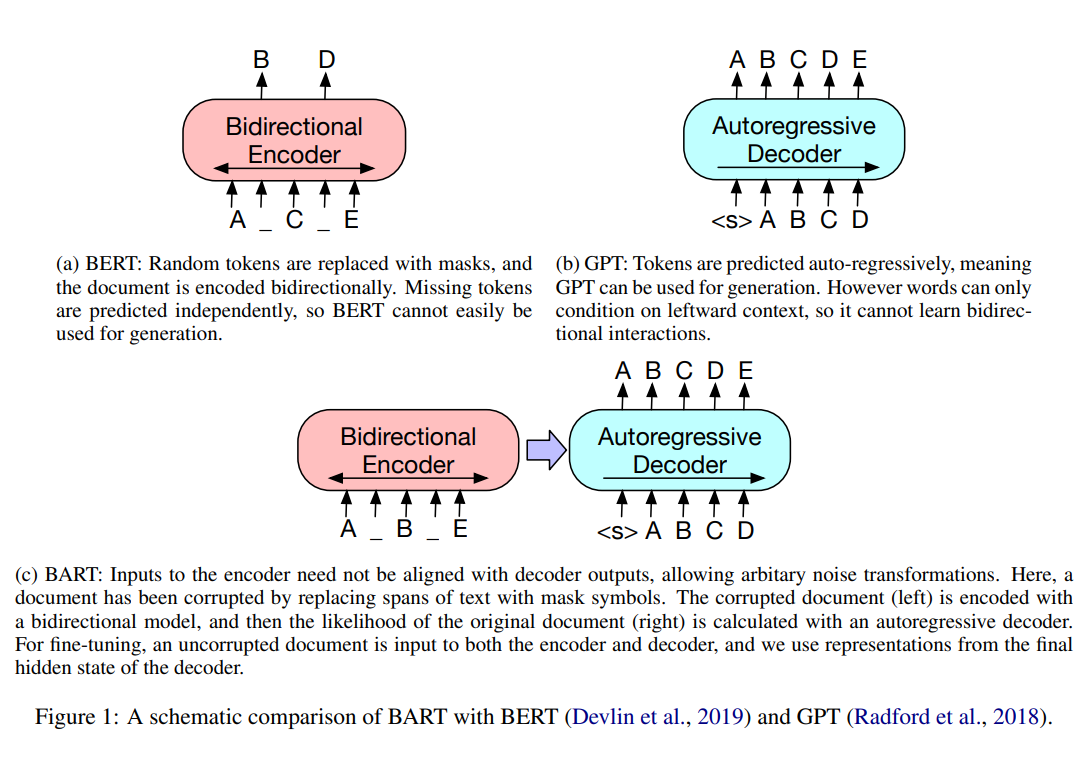

In [2]:
from IPython.display import Image
Image("test.png")

we'll start the training of the tokenizer with <s>, </s>, <pad> to be used as special tokens for indicating beginning of sentence, end of sentence and padding repectively. Then, we'll save the tokenizer model, which is basically two files :

- vocab.json which is a list of the most frequent tokens ranked by frequency.
- merges.txt which is a list of all the merges.

In [3]:
import os
# https://www.kaggle.com/code/yashsrivastava51213/bart-pretraining-from-scratch/notebook
# Get the paths of all the books in the "books" folder
folder_path = './books'
book_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

# Byte-level byte-pair encoding tokenizer
tokenizer = ByteLevelBPETokenizer()

for book_path in book_paths:
    print(f"Reading book: {book_path}")
    tokenizer.train(files=[book_path], vocab_size=50000, min_frequency=2, special_tokens=[
        "<s>",
        "</s>",
        "<pad>"
    ])

# Save the tokenizer model in a folder (contains 2 files - vocab.json and merges.txt)
output_folder = 'output_BART'
os.makedirs(output_folder, exist_ok=True)
tokenizer.save_model(output_folder)

Reading book: ./books/shakespeare.txt



Reading book: ./books/charles-dickens-oliver-twist.txt



Reading book: ./books/faust-eine-tragodie.txt



Reading book: ./books/dostoyevsky-the-idiot.txt



Reading book: ./books/james-joyce-ulysses.txt



Reading book: ./books/jane-austen-pride-prejudice.txt



Reading book: ./books/kant-kritk-der-reinen-vernuft.txt



Reading book: ./books/dante-divina-commedia.txt



Reading book: ./books/nietzsche-zarathustra.txt





['output_BART/vocab.json', 'output_BART/merges.txt']

We'll use the ByteLevelBPETokenizer and use BertProcessing to enocode some sentences. 

In [4]:
# Just for testing whether the tokenizer is working or not
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer = ByteLevelBPETokenizer(
    "./output_BART/vocab.json",
    "./output_BART/merges.txt",)

tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)

tokenizer.enable_truncation(max_length=512)

# print(torch.cuda.is_available()) 

print(tokenizer.encode('Et tu').tokens)

['<s>', 'E', 't', 'Ġt', 'u', '</s>']


for more details [here](https://huggingface.co/transformers/v4.5.1/model_doc/bart.html)

In [5]:
# Trying the BART model

# Set the config
config = BartConfig(
    vocab_size=50000,
    max_position_embeddings=32,
    num_attention_heads=4,
    num_hidden_layers=1,
    type_vocab_size=1,
)

# We can set the following parameters : (Ref. https://huggingface.co/transformers/v4.5.1/model_doc/bart.html)


tokenizer = BartTokenizerFast.from_pretrained("./output_BART", max_len=64)  # This loads the model

model = AutoModelForMaskedLM.from_config(config=config)  # AutoModel automatically recognizes.
print(model.num_parameters())   # Don't go too heavy, you might break the Kaggle platform !!! 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


403988480


our data is in a line by line fashion. we'll use that only to set the dataset and the dataset_collator.

In [6]:
# Building our dataset - This cell breaks the runtime limits provided under the free limits.
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path='./output.txt',
    block_size=16,
)

# Batching data
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/transformers/data/datasets/language_modeling.py:123: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


We'll set the TrainingArguments and Trainer and get the model ready for training.

In [7]:
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import BertTokenizerFast
from datasets import load_dataset
from transformers import pipeline
from transformers import set_seed
from transformers import Trainer
from datasets import DatasetDict
import transformers
import numpy as np
import datasets
import logging 
import torch
import os
N_GPUS = 1
TRAIN_EPOCHS = 2
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
MAX_LEN = 128
LOGGING_STEPS = 64
SAVE_STEPS = 10240  # reduce it to a smaler value like 512 if you want to save checkpoints
SAVE_TOTAL_LIMIT = 2

set_seed(123)
training_args = TrainingArguments(
    output_dir='output_BART',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_gpu_train_batch_size=64,
    save_steps=5000,
    save_total_limit=2,
    prediction_loss_only=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset
)

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


In [8]:
trainer.train()
trainer.save_model('output_BART')

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
2023-05-31 12:44:43.683166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 12:44:44.122105

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: mzamini (phoenix92). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,6.396300
1000,6.051800
1500,6.037200
2000,6.031000
2500,6.036800
3000,6.028400
3500,6.029200
4000,6.015400
4500,6.014500
5000,6.025100


/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

Now we'll check whether the model has performed like we think or not. We'll make use of pipeline to check whether our model can fill masks appropriately or not.

In [9]:
# Check if the model actaully trained or not !
fill_mask = pipeline(
    'fill-mask',
    model='output_BART',
    tokenizer='output_BART'
)

print(fill_mask("Write a <mask>"))  # This gives a list of scores and the respective tokens...
# Once the model is trained, it can be used further task such as NER, POS etc.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'score': 0.047952983528375626, 'token': 819, 'token_str': 'the', 'sequence': 'Write athe'}, {'score': 0.04712499678134918, 'token': 43, 'token_str': 'I', 'sequence': 'Write aI'}, {'score': 0.027664877474308014, 'token': 42, 'token_str': 'H', 'sequence': 'Write aH'}, {'score': 0.027483128011226654, 'token': 82, 'token_str': 'p', 'sequence': 'Write ap'}, {'score': 0.024575235322117805, 'token': 69, 'token_str': 'c', 'sequence': 'Write ac'}]


Log in to your HuggingFace account and copy/create an accesss token.
Now, create a new model and note down the name of the repo.
Copy your access token by running the cell below. After that, you'll upload the model from here !!

In [10]:
from huggingface_hub import notebook_login
notebook_login()

upload your custom model to the model repo you just created(make sure that the model is created and then the cell below is runned.) Change your username and the model repo name, and now you have a custom HuggingFace model.

In [11]:
from huggingface_hub import HfApi
api = HfApi()

# Upload all the content from the local folder to your repo.

api.upload_folder(
    folder_path="./shakespere_BART",
    repo_id="./shakespere_BART",
    repo_type="model",
)